In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip freeze > /content/drive/MyDrive/eardrum/requirements.txt

# 함수

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
from keras import backend as K

# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [ ]:
# # Load the best model
# best_model = load_model("/content/drive/MyDrive/eardrum/model/att_model_2_class_other.h5",
#                         custom_objects={'precision': precision,
#                                           'recall': recall,
#                                           'f1': f1})

In [ ]:
# Load the best model
best_model = load_model("/content/drive/MyDrive/eardrum/model/crop_model.h5",
                        custom_objects={'precision': precision,
                                          'recall': recall,
                                          'f1': f1})

In [ ]:
data_path = '/content/drive/MyDrive/eardrum2/last_test_png/'

In [ ]:
def inference(img_path, model, img_height=299, img_width=299):
  img = image.load_img(img_path, target_size=(img_height, img_width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array/255

  predictions = model.predict(img_array)

  # 클래스 및 클래스 확률 출력
  class_labels = ["Abnormal", "Normal"]  # 클래스 라벨 설정
  predicted_class = np.argmax(predictions)
  predicted_class_label = class_labels[predicted_class]
  Abnormal_probability = predictions[0][0]

  # 이미지 출력
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print("1. 이미지 path:", img_path)
  print("2. 분류된 class:", predicted_class_label)
  print("3. Abnormal 확률:", Abnormal_probability)

  return img_path, predicted_class_label, Abnormal_probability

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

def inference_crop(img_path, model, img_height=299, img_width=299):
  img_ori = image.load_img(img_path)
  # img_ori = tf.image.central_crop(img_ori, central_fraction=0.8)
  img = tf.image.resize(img_ori, [img_height, img_width])
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255

  predictions = model.predict(img_array)

  # 클래스 및 클래스 확률 출력
  class_labels = ["Abnormal", "Normal"]  # 클래스 라벨 설정
  predicted_class = np.argmax(predictions)
  predicted_class_label = class_labels[predicted_class]
  Abnormal_probability = predictions[0][0]
  normal_probability = predictions[0][1]

  # 이미지 출력
  plt.imshow(img_ori)
  plt.axis('off')
  plt.show()

  # print("1. 이미지 path:", img_path)
  # print("분류된 class:", predicted_class_label)
  # print("3. Abnormal 확률:", Abnormal_probability)

  if predicted_class_label == "Abnormal":
    print(f'중이염 및 외이도염으로 판별되었습니다.')
    print(f'중이염 및 외이도염이 있을 확률이 {Abnormal_probability:.4f}입니다.')

  else:
    print(f'정상으로 판별되었습니다.')
    print(f'정상일 확률이 {normal_probability:.4f}입니다.')

  return img_path, predicted_class_label, Abnormal_probability

In [ ]:
img_path = data_path+'7.png'

1/1 [==============================] - 0s 351ms/step


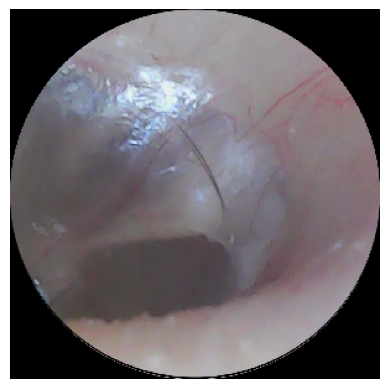

1. 이미지 path: /content/drive/MyDrive/eardrum2/last_test_png/4.png
2. 분류된 class: Normal
3. Abnormal 확률: 0.10928337


In [ ]:
path, label, prob = inference(img_path, best_model)

In [ ]:
print("1. 이미지 path:", path)
print("2. 분류된 class:", label)
print("3. Abnormal 확률:", prob)

1. 이미지 path: /content/drive/MyDrive/eardrum2/last_test_png/4.png
2. 분류된 class: Normal
3. Abnormal 확률: 0.10928337


1/1 [==============================] - 1s 576ms/step


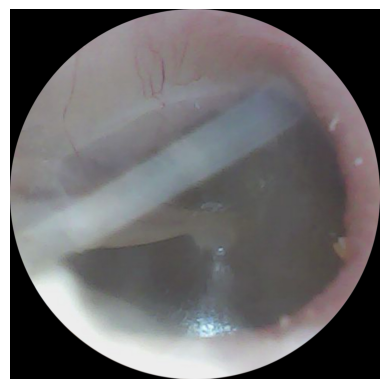

정상으로 판별되었습니다.
정상일 확률이 0.8199입니다.


In [ ]:
path, label, prob = inference_crop(img_path, best_model)

# ROC

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Assuming the same rescaling was applied to the training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Replace the following path with the path to your test data
test_data_path = '/content/drive/MyDrive/eardrum2/combined_data_2_png/test/'

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),  # Make sure to match the input size of your model
    color_mode='rgb',  # or 'grayscale' depending on your model
    batch_size=16,  # Can be adjusted according to your needs
    class_mode='categorical',  # Use 'binary' for binary classification
    shuffle=False  # Important for maintaining order
)

Found 106 images belonging to 2 classes.


In [ ]:
y_pred = best_model.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 44s 6s/step


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# 실제 레이블 가져오기
true_classes = test_generator.classes

# ROC curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(true_classes, y_pred[:, 0])
auc = roc_auc_score(true_classes, y_pred[:, 0])

# Youden's J statistic 계산
Youdens_J = tpr - fpr
optimal_threshold = thresholds[np.argmax(Youdens_J)]

# 최적의 threshold 적용
predicted_classes_threshold = (y_pred[:, 0] >= optimal_threshold).astype(int)

# 최적의 threshold 및 AUC 출력
print("Optimal Threshold:", optimal_threshold)
print("AUC:", auc)

Optimal Threshold: 0.51096106
AUC: 0.8419753086419752


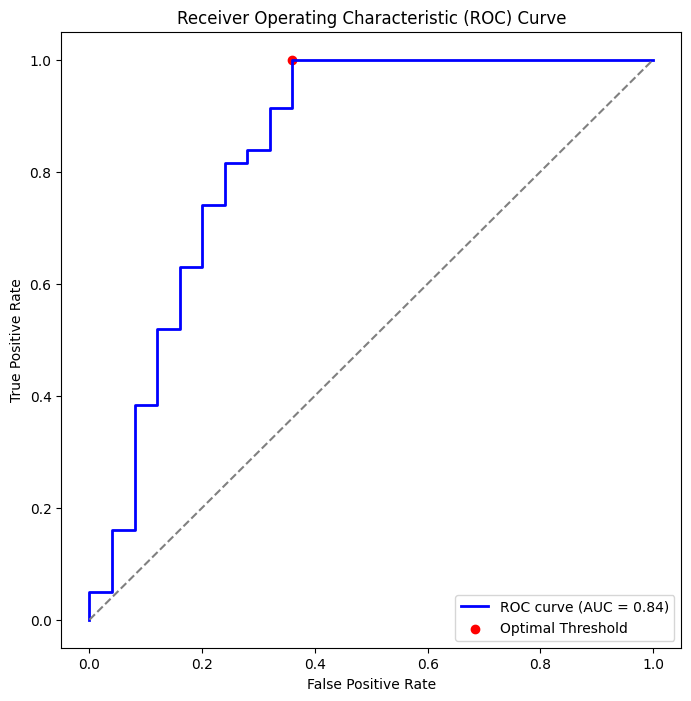

In [ ]:
import matplotlib.pyplot as plt

# 실제 레이블 가져오기
true_classes = test_generator.classes

# ROC curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(true_classes, y_pred[:, 0])
auc = roc_auc_score(true_classes, y_pred[:, 0])

# Youden's J statistic 계산
Youdens_J = tpr - fpr
optimal_threshold = thresholds[np.argmax(Youdens_J)]

# ROC curve 그리기
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[np.argmax(Youdens_J)], tpr[np.argmax(Youdens_J)], color='red', marker='o', label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()